# RAW-CAPTURE on Aspen-8

In this we are going to show how to access "raw" measurement data with Quilt.

In [1]:
import os
from pyquil import Program, get_qc

os.environ['QPU_COMPILER_URL'] = "https://translation.services.production.qcs.rigetti.com"
qc = get_qc('Aspen-8')

In [3]:
cals = qc.compiler.get_quilt_calibrations()

## Peeking at a MEASURE calibration
We first take a peek at how a measurement operation is specified. We can dot his by looking at the corresponding calibration. Below we consider the calibration for `MEASURE 0`.

In [4]:
from pyquil.quilatom import Qubit, Frame
from pyquil.quilbase import Pulse, Capture, DefMeasureCalibration

qubit = Qubit(0)

measure_defn = next(defn for defn in cals.calibrations 
                    if isinstance(defn, DefMeasureCalibration) and defn.qubit == qubit)

print(measure_defn)

DEFCAL MEASURE 0 addr:
    FENCE 0
    DECLARE q0_unclassified REAL[2]
    NONBLOCKING PULSE 0 "ro_tx" flat(duration: 4.6e-07, iq: 1.0, scale: 0.133352143216333, phase: 0.0, detuning: 0.0)
    NONBLOCKING CAPTURE 0 "ro_rx" boxcar_kernel(duration: 4.6e-07, scale: 1.0, phase: 0.8638879471033664, detuning: 0.0) q0_unclassified[0]
    PRAGMA FILTER-NODE q0_unclassified "{'module':'lodgepole.filters.io','filter_type':'DataBuffer','source':'q0_ro_rx/filter','publish':true,'params':{},'_type':'FilterNode'}"
    PRAGMA LOAD-MEMORY q0_unclassified "q0_unclassified[0]"
    PRAGMA FILTER-NODE q0_classified "{'module':'lodgepole.filters.classifiers','filter_type':'SingleQLinear','source':'q0_ro_rx/filter','publish':false,'params':{'a':[1.0,0.0],'threshold':0.0019404207501184005},'_type':'FilterNode'}"
    PRAGMA FILTER-NODE q0 "{'module':'lodgepole.filters.io','filter_type':'DataBuffer','source':'q0_classified','publish':true,'params':{},'_type':'FilterNode'}"
    PRAGMA LOAD-MEMORY q0 "addr"
    

There are a few things note about the above:

1. The basic structure of `MEASURE 0 addr` is to apply a pulse on the `"ro_tx"` frame, and then perform a capture on the corresponding `"ro_rx"` frame.
2. Although the user may perform `MEASURE 0 ro`, the memory location required for this is a bit. Under the hood, `CAPTURE` writes a complex IQ value to the `REAL[2]` region `q0_unclassified`.
3. The wrangling in order to map from `q0_unclassified` to `addr` is controlled through `PRAGMA` operations. These are important for downstream processing and execution of the Quil program. Tamper with them at your own risk!

## RAW-CAPTURE experiments

The value stored in `q0_unclassified` has already been processed on hardware: in particular, it is produced by demodulating a passband signal and then integrating against the `CAPTURE` waveform. What `RAW-CAPTURE` does is give you, the user, access to the raw values of that passband signal. In the following, execute programs with `RAW-CAPTURE`, and plot their results.

Before we begin, it will be useful to get some data associated with the above `MEASURE` calibration. In particular, the `PULSE` and `CAPTURE` operations, as well as the frame definition for `0 "ro_rx"`.

In [5]:
pulse = next(i for i in measure_defn.instrs if isinstance(i, Pulse))
print(pulse, "\n")
capture = next(i for i in measure_defn.instrs if isinstance(i, Capture))
print(capture, "\n")
frame = Frame([qubit], "ro_rx")
frame_defn = cals.frames[frame]
print(frame_defn)

NONBLOCKING PULSE 0 "ro_tx" flat(duration: 4.6e-07, iq: 1.0, scale: 0.133352143216333, phase: 0.0, detuning: 0.0) 

NONBLOCKING CAPTURE 0 "ro_rx" boxcar_kernel(duration: 4.6e-07, scale: 1.0, phase: 0.8638879471033664, detuning: 0.0) q0_unclassified[0] 

DEFFRAME 0 "ro_rx":
    DIRECTION: "rx"
    INITIAL-FREQUENCY: 7262779258.52148
    HARDWARE-OBJECT: "q0_ro_rx"
    SAMPLE-RATE: 2000000000.0



### An almost-trivial example

First, let's just run a `RAW-CAPTURE` instruction. We will apply this to the above `CAPTURE` frame, i.e. `0 "ro_rx"`, and for the same duration the `CAPTURE`. The principal difference is that rather than read-out to a memory region of length 2, we will need many more. It is easy to compute the size $n$ of the output, namely
\begin{equation}
n = \left \lceil{t \cdot f_s}\right \rceil , 
\end{equation}
where $t$ is the duration in seconds, $f_s$ is the sample rate in Hz (which is part of the frame definition), and $ \left \lceil x \right \rceil $ denotes the smallest integer not less than $x$.


In [6]:
from math import ceil

duration = capture.kernel.duration
sample_rate = frame_defn.sample_rate
memory_length = ceil(duration * sample_rate)

raw_capture_no_pulse = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(1000)
print(raw_capture_no_pulse)

DECLARE raw REAL[920]
RAW-CAPTURE 0 "ro_rx" 4.6e-07 raw[0]



In [7]:
exe = qc.compiler.native_quil_to_executable(raw_capture_no_pulse)
qc.run(exe)

In [8]:
raw_results_no_pulse = qc.qam.read_memory(region_name='raw')

Raw capture results are by default represented as integers in the interval $[-2^{15}, 2^{15}]$. For many analyses you may prefer to normalize to the range $[-1,1]$.

In [9]:
print("shape", raw_results_no_pulse.shape)
print("data", raw_results_no_pulse)

shape (1000, 920)
data [[-1748.  -228.  -532. ...   184.   372.   372.]
 [ -500.   380.  -204. ...  -488.  -248.  -184.]
 [  204.   564.  -232. ...     8.   304.  -864.]
 ...
 [ -452.  -684. -1044. ...   -48.   584.   160.]
 [   68.   100.  -328. ...  -488.   168.  -376.]
 [  328.   740.    56. ...  -364. -1380. -1040.]]


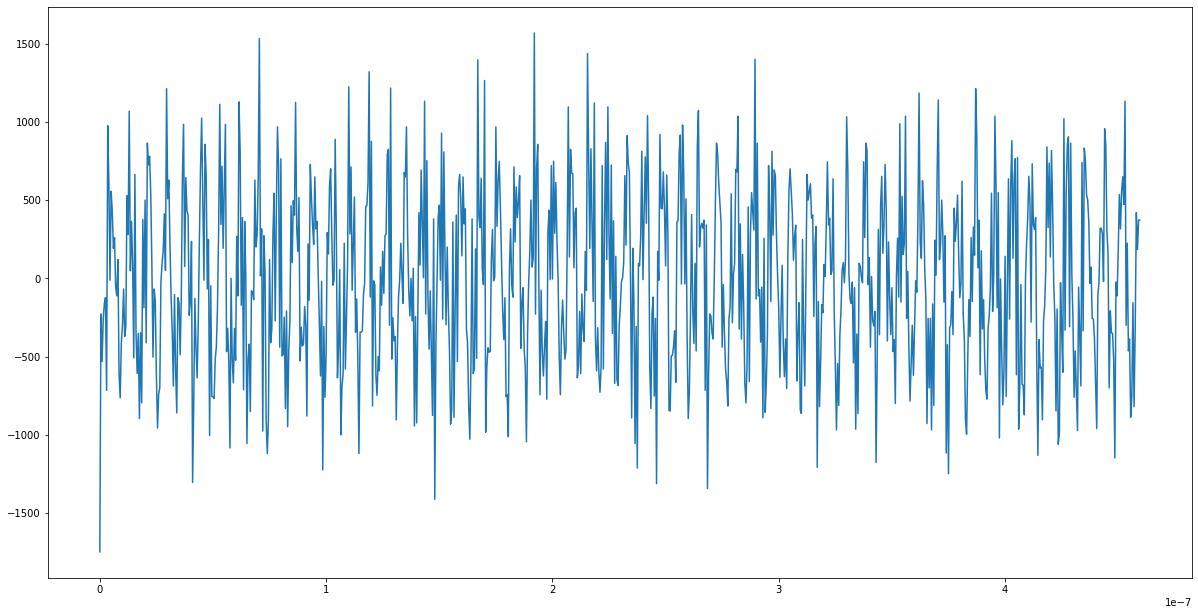

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.gcf().set_size_inches(20.5, 10.5)
plt.plot(np.arange(len(raw_results_no_pulse[0,:]))/sample_rate, raw_results_no_pulse[0,:])
plt.show()

In [11]:
avg_results_no_pulse = raw_results_no_pulse.mean(axis=0) / (2**15)

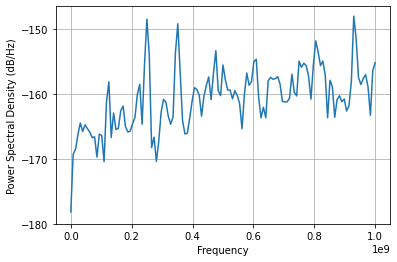

In [12]:
plt.psd(avg_results_no_pulse, Fs=sample_rate)
plt.show()

### Applying a `PULSE` before `RAW-CAPTURE`

Recall how measurements are usually done: first there is a pulse on the `"ro_tx"` frame, and then a capture on the `"ro_rx"` frame. We modify our above program by including the `PULSE` operation associated with the vanilla measurement.

In [13]:
raw_capture_pulse = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    pulse,
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(1000)
print(raw_capture_pulse)

DECLARE raw REAL[920]
NONBLOCKING PULSE 0 "ro_tx" flat(duration: 4.6e-07, iq: 1.0, scale: 0.133352143216333, phase: 0.0, detuning: 0.0)
RAW-CAPTURE 0 "ro_rx" 4.6e-07 raw[0]



In [14]:
exe = qc.compiler.native_quil_to_executable(raw_capture_pulse)
qc.run(exe)

raw_results_pulse = qc.qam.read_memory(region_name='raw')
avg_results_pulse = raw_results_pulse.mean(axis=0) / 2**15

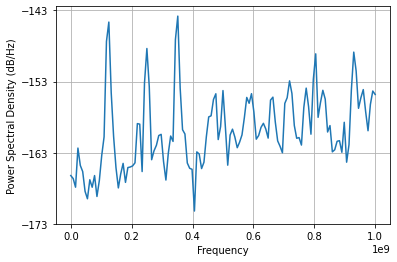

In [15]:
plt.psd(avg_results_pulse, Fs=sample_rate)
plt.show()

### Capturing an excited qubit

Finally, we extend the above by first exciting the qubit, by applying a `RX(pi)` gate.

In [16]:
raw_capture_excited = Program(     
    f'DECLARE raw REAL[{memory_length}]',
    f'RX(pi) {qubit}',
    pulse,
    f'RAW-CAPTURE {frame} {duration} raw'
).wrap_in_numshots_loop(1000)
print(raw_capture_excited)

DECLARE raw REAL[920]
RX(pi) 0
NONBLOCKING PULSE 0 "ro_tx" flat(duration: 4.6e-07, iq: 1.0, scale: 0.133352143216333, phase: 0.0, detuning: 0.0)
RAW-CAPTURE 0 "ro_rx" 4.6e-07 raw[0]



In [17]:
exe = qc.compiler.native_quil_to_executable(raw_capture_excited)
qc.run(exe)

raw_results_excited = qc.qam.read_memory(region_name='raw')
avg_results_excited = raw_results_excited.mean(axis=0) / 2**15

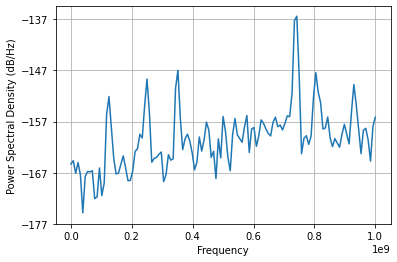

In [18]:
plt.psd(avg_results_excited, Fs=sample_rate)
plt.show()

### TODO

Discuss readout classification.

## Some Restrictions May Apply

Performing a `RAW-CAPTURE` operation places a number of demands on the underlying hardware, and thus comes with a few constraints. We demonstrate these here.

### Capture duration exceeds maximum length

A `RAW-CAPTURE` operation can capture at most 8192 samples per shot, which puts a limit of $\frac{8192}{f_s}$ seconds for the duration, where $f_s$ is the frame's sample rate.

In [19]:
duration = 5e-6
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
).wrap_in_numshots_loop(1)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

ERROR - QPU Compiler native_quilt_to_binary failed: RAW-CAPTURE 0 "ro_rx" 5e-06 raw[0] would require 10000 samples, butat most 8192 are allowed. Consider using a duration of < 4.096e-06 seconds.


QPU Compiler native_quilt_to_binary failed: RAW-CAPTURE 0 "ro_rx" 5e-06 raw[0] would require 10000 samples, butat most 8192 are allowed. Consider using a duration of < 4.096e-06 seconds.


### Number of samples in a job exceeds maximum

There is a total limit of $2^{24}$ samples per job, i.e. `duration * sample_rate * num_shots` cannot exceed $2^24$.

In [20]:
duration = 1e-06
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
).wrap_in_numshots_loop(100000)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

ERROR - QPU Compiler native_quilt_to_binary failed: RAW-CAPTURE would require DMA buffer of size 381.4697265625 MB but the maximum allowed is 32.0 MB.
For duration 1e-06 seconds this places a limit of at most 8388 shots.


QPU Compiler native_quilt_to_binary failed: RAW-CAPTURE would require DMA buffer of size 381.4697265625 MB but the maximum allowed is 32.0 MB.
For duration 1e-06 seconds this places a limit of at most 8388 shots.


### `RAW-CAPTURE` precludes the use of other capture operations

Due to the hardware requirements associated with `RAW-CAPTURE`, the following limits are currently imposed:

* there can be at most one `RAW-CAPTURE` operation per program, and
* if a program includes `RAW-CAPTURE`, then it cannot also include `CAPTURE` operations.

In [21]:
duration = 1e-06
samples = ceil(sample_rate*duration)
rrr = Program(
    f'DECLARE raw REAL[{samples}]', 
    'DECLARE ro BIT',
    'MEASURE 1 ro',
    f'RAW-CAPTURE 0 "ro_rx" {duration} raw'
)

try:
    exe = qc.compiler.native_quil_to_executable(rrr)
except Exception as e:
    print(e)

ERROR - QPU Compiler native_quilt_to_binary failed: Capture conflict: RAW-CAPTURE 0 "ro_rx" 1e-06 raw[0] precludes the presence of any other capture instructions, but NONBLOCKING CAPTURE 1 "ro_rx" boxcar_kernel(duration: 2.44e-06, scale: 1.0, phase: 0.6576294712202266, detuning: 0.0) q1_unclassified[0] was observed.


QPU Compiler native_quilt_to_binary failed: Capture conflict: RAW-CAPTURE 0 "ro_rx" 1e-06 raw[0] precludes the presence of any other capture instructions, but NONBLOCKING CAPTURE 1 "ro_rx" boxcar_kernel(duration: 2.44e-06, scale: 1.0, phase: 0.6576294712202266, detuning: 0.0) q1_unclassified[0] was observed.
